Transposed cluster statistics saved to clusters_conductance_transposed.csv


Graph: Original
  Number of clusters in range: 4
  Mean conductance: 0.0111
  Min conductance: 0.0110
  Max conductance: 0.0113

Graph: wncp_fallback
  Number of clusters in range: 4
  Mean conductance: 0.0050
  Min conductance: 0.0048
  Max conductance: 0.0053

Graph: wncp_strict
  Number of clusters in range: 4
  Mean conductance: 0.0068
  Min conductance: 0.0065
  Max conductance: 0.0070

Graph: random
  Number of clusters in range: 4
  Mean conductance: 0.0049
  Min conductance: 0.0048
  Max conductance: 0.0053



## according to clusters.tab file

In [11]:

graph_clusters = {
    "Original": {
        "graph": "/home/ofrie.r/ncp_expand/datasets/facebook/facebook_combined.txt",
        "cluster": "/home/ofrie.r/ncp_expand/datasets/facebook/ncp_original_graph/ncp.facebook_combined.clusters.tab"
    }#,
    # # "wncp_fallback": {
    # #     "graph": "/home/ofrie.r/ncp_expand/target/wncp/fallback/facebook_fallback_wncp_100.edgelist",
    # #     "cluster": "/home/ofrie.r/ncp_expand/target/ncp_plots/facebook/fallback/ncp.facebook_fallback_wncp_100.clusters.tab"
    # # },
    # # "wncp_strict": {
    # #     "graph": "/home/ofrie.r/ncp_expand/target/wncp/strict/facebook_wncp_100.edgelist",
    # #     "cluster": "/home/ofrie.r/ncp_expand/target/ncp_plots/facebook/strict/ncp.facebook_wncp_100.clusters.tab"
    # # },
    # "random": {
    #     "graph": "/home/ofrie.r/ncp_expand/target/random/facebook_random_100.edgelist",
    #     "cluster": "/home/ofrie.r/ncp_expand/target/ncp_plots/facebook/random/ncp.facebook_random_100.clusters.tab"
    # },
    # "random_old": {
    #     "graph": "/home/ofrie.r/ncp_expand/target/random/facebook_random_100_old.edgelist",
    #     "cluster": "/home/ofrie.r/ncp_expand/target/ncp_plots/facebook/random/old/ncp.facebook_random_100.clusters.tab"
    # }
    # "LiveJournal1": {
    #     "graph": "/home/ofrie.r/soc-LiveJournal1.txt",
    #     "cluster": "/home/ofrie.r/ncp_expand/snap/ncp.soc-LiveJournal1.clusters.tab"
    # }
}

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def compute_conductance(G, cluster_nodes):
    """Compute conductance of a given set of nodes in graph G."""
    S = set(cluster_nodes)
    if len(S) == 0 or len(S) == len(G):
        return 0.0  # degenerate cases

    cut_edges = 0
    vol_S = 0

    for u in S:
        neighbors = set(G.neighbors(u))
        deg_u = len(neighbors)
        vol_S += deg_u
        cut_edges += len(neighbors - S)

    vol_notS = 2 * G.number_of_edges() - vol_S
    denom = min(vol_S, vol_notS)
    if denom == 0:
        return 0.0

    return cut_edges / denom


def verify_cluster_file(graph, cluster_file, tol=1e-6, make_plot=True, loglog=True, save_csv=False, csv_path="../target/verification_results.csv"):
    """
    Compare NCP values from cluster file with recomputed conductance values.
    Prints per-cluster results, mismatch statistics with cluster sizes, and optionally plots.
    """
    sizes = []
    phi_file_vals = []
    phi_calc_vals = []
    mismatch_sizes = []

    with open(cluster_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()
            size = int(parts[0])
            phi_file = float(parts[1])
            nodes = list(map(int, parts[2:]))

            phi_calc = compute_conductance(graph, nodes)

            sizes.append(size)
            phi_file_vals.append(phi_file)
            phi_calc_vals.append(phi_calc)

            if abs(phi_file - phi_calc) > tol:
                mismatch_sizes.append(size)

    # --- Summary ---
    diffs = [abs(f - c) for f, c in zip(phi_file_vals, phi_calc_vals)]
    
    print("\n=== Verification Summary ===")
    print(f"Clusters checked: {len(sizes)}")
    print(f"Mismatches: {len(mismatch_sizes)}")
    if mismatch_sizes:
        print(f"Cluster sizes with mismatches: {sorted(mismatch_sizes)}")

    # --- Statistics ---
    min_diff = np.min(diffs)
    max_diff = np.max(diffs)
    mean_diff = np.mean(diffs)
    median_diff = np.median(diffs)
    min_idx = diffs.index(min_diff)
    max_idx = diffs.index(max_diff)
    print("\n=== Conductance Differences Statistics ===")
    print(f"Min difference: {min_diff:.6e} (cluster size {sizes[min_idx]})")
    print(f"Max difference: {max_diff:.6e} (cluster size {sizes[max_idx]})")
    print(f"Mean difference: {mean_diff:.6e}")
    print(f"Median difference: {median_diff:.6e}")

    # --- Plot ---
    if make_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(sizes, phi_file_vals, label="Phi (file)", marker="o", alpha=0.7)
        plt.plot(sizes, phi_calc_vals, label="Phi (calc)", marker="x", alpha=0.7)
        
        plt.xlabel("Cluster size")
        plt.ylabel("Conductance (Phi)")
        plt.title("NCP Verification")
        plt.legend()
        plt.grid(True, which="both", alpha=0.3)

        if loglog:
            plt.xscale("log")
            plt.yscale("log")

        plt.tight_layout()
        plt.show()
    
    if save_csv:
        df_out = pd.DataFrame({
            "ClusterSize": sizes,
            "Phi_file": phi_file_vals,
            "Phi_calc": phi_calc_vals,
            "AbsDifference": diffs,
            "Mismatch": [abs(f - c) > tol for f, c in zip(phi_file_vals, phi_calc_vals)]
        })
        df_out.to_csv(csv_path, index=False)
        print(f"\nResults saved to {csv_path}")

    return sizes, phi_file_vals, phi_calc_vals, mismatch_sizes, diffs



=== Verification Summary ===
Clusters checked: 2002
Mismatches: 1721
Cluster sizes with mismatches: [9, 10, 11, 12, 13, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 233, 234, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,

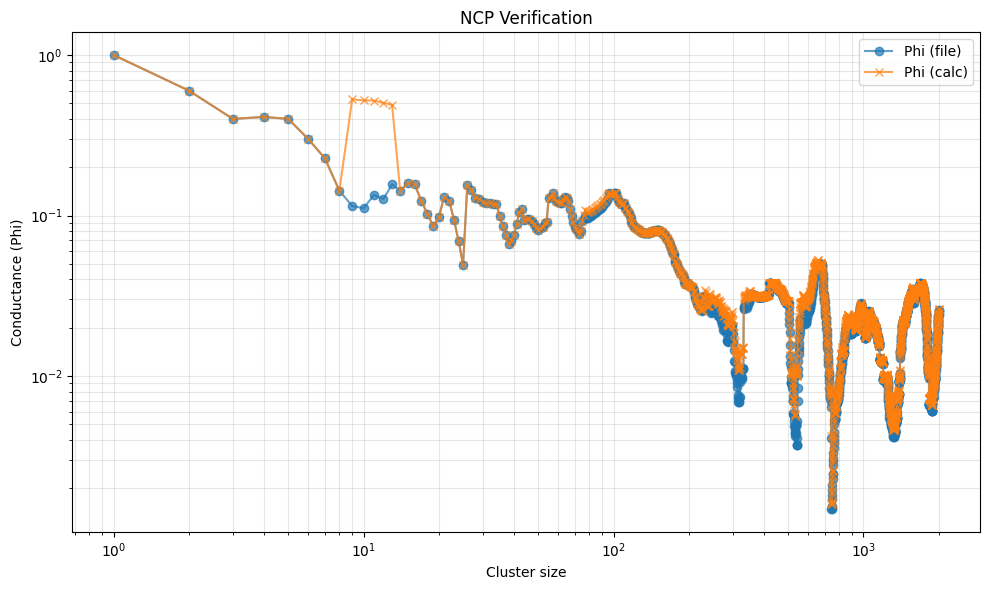

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  

In [13]:

# Example usage:
G = nx.read_edgelist(graph_clusters["Original"]["graph"], nodetype=int)
verify_cluster_file(G, graph_clusters["Original"]["cluster"])

In [4]:
graph_clusters

{'Original': {'graph': '/home/ofrie.r/ncp_expand/datasets/facebook/facebook_combined.txt',
  'cluster': '/home/ofrie.r/ncp_expand/datasets/facebook/ncp_original_graph/ncp.facebook_combined.clusters.tab'}}

## plot the calculated ncp

In [37]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_multiple_ncp(graph_clusters, tol=1e-6, loglog=True):
    """
    Plot NCP curves for multiple graph variants using the graph_clusters dict.
    Prints mismatch statistics and plots thinner lines with smaller markers.
    """
    plt.figure(figsize=(10, 6))
    
    for label, paths in graph_clusters.items():
        print(f"\nProcessing {label}...")
        G = nx.read_edgelist(paths["graph"], nodetype=int)
        sizes, phi_file_vals, phi_calc_vals, mismatches_sizes = verify_cluster_file(
            G, paths["cluster"], tol=tol, make_plot=False, loglog=False
        )
        
        plt.plot(sizes, phi_calc_vals, marker="o", markersize=4, linewidth=1.0, alpha=0.7, label=label)
        
        if mismatches_sizes:
            # Map cluster size to index
            size_to_index = {size: idx for idx, size in enumerate(sizes)}
            diffs = [abs(phi_file_vals[size_to_index[s]] - phi_calc_vals[size_to_index[s]]) for s in mismatches_sizes]
            
            print(f"⚠️ {label}: {len(mismatches_sizes)} mismatches at cluster sizes {mismatches_sizes}")
            print(f"   ΔPhi stats: min={np.min(diffs):.2e}, mean={np.mean(diffs):.2e}, max={np.max(diffs):.2e}")
        else:
            print(f"✅ {label}: all clusters consistent")
    
    plt.xlabel("Cluster size")
    plt.ylabel("Conductance (Phi)")
    plt.title("NCP Comparison Across Graph Variants")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    
    if loglog:
        plt.xscale("log")
        plt.yscale("log")
    
    plt.tight_layout()
    plt.show()



Processing Original...



=== Verification Summary ===
Clusters checked: 2002
Mismatches: 1721
Cluster sizes with mismatches: [9, 10, 11, 12, 13, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 233, 234, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,

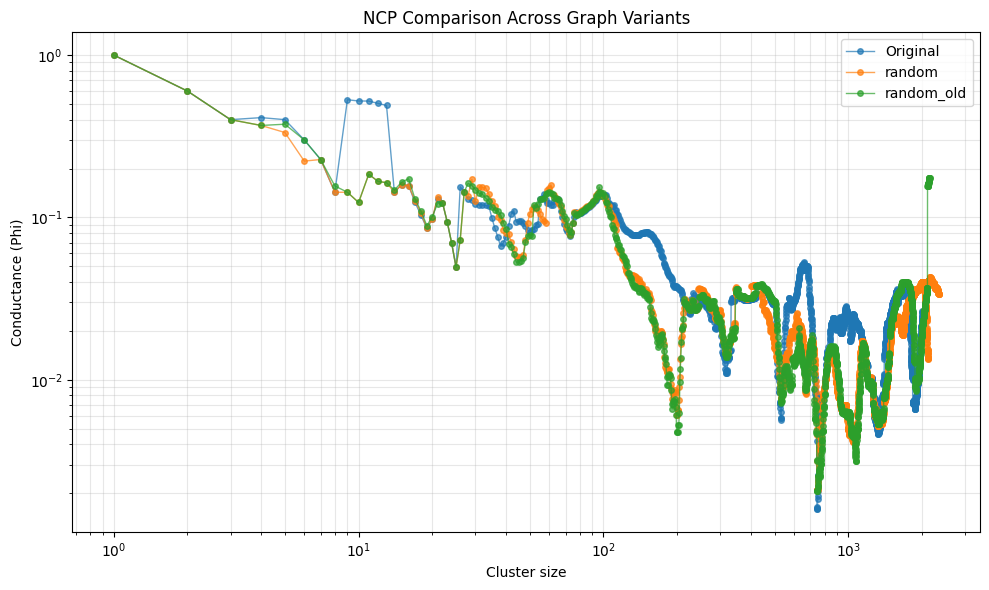

In [38]:
plot_multiple_ncp(graph_clusters, tol=1e-6, loglog=True)


### get cluster from a processed graph, and check conductance on original graph

In [48]:
import networkx as nx

# Reload the Original and Random graphs
G_original = nx.read_edgelist(graph_clusters["Original"]["graph"], nodetype=int)
G_random   = nx.read_edgelist(graph_clusters["random"]["graph"], nodetype=int)
cluster_size = 200
# Function to get nodes and phi from a cluster file
def get_cluster_info(cluster_file, cluster_size):
    """Return (phi_file, nodes) for the given cluster size."""
    with open(cluster_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            size = int(parts[0])
            phi_file = float(parts[1])
            nodes = list(map(int, parts[2:]))
            if size == cluster_size:
                return phi_file, nodes
    return None, None

# Get cluster info from Random cluster file
phi_file, nodes = get_cluster_info(graph_clusters["random"]["cluster"], cluster_size)

if nodes:
    # Recompute Phi on both graphs
    phi_original = compute_conductance(G_original, nodes)
    phi_random   = compute_conductance(G_random, nodes)
    
    print(f"Cluster size {cluster_size} nodes: {nodes}")
    print(f"Phi in Random cluster file: {phi_file:.6f}")
    print(f"Phi on Original graph:      {phi_original:.6f}")
    print(f"Phi on Random graph:        {phi_random:.6f}")
else:
    print(f"No cluster of size {cluster_size} found in the Random cluster file.")


Cluster size 200 nodes: [723, 826, 734, 727, 770, 849, 766, 688, 846, 785, 756, 824, 830, 750, 854, 828, 704, 847, 740, 845, 784, 693, 842, 777, 716, 751, 812, 711, 778, 726, 695, 853, 752, 844, 760, 799, 724, 820, 748, 745, 738, 821, 737, 731, 783, 694, 834, 701, 848, 827, 759, 754, 706, 815, 780, 837, 741, 797, 841, 781, 763, 794, 705, 690, 773, 715, 709, 700, 831, 710, 758, 792, 805, 835, 779, 762, 836, 718, 817, 814, 719, 722, 851, 755, 761, 744, 787, 843, 687, 764, 838, 739, 728, 713, 793, 829, 730, 810, 809, 686, 795, 697, 823, 703, 757, 807, 772, 775, 749, 803, 747, 808, 765, 840, 813, 721, 800, 819, 774, 699, 790, 850, 832, 742, 708, 743, 696, 880, 746, 816, 855, 852, 717, 833, 786, 691, 707, 771, 796, 782, 768, 736, 818, 767, 712, 802, 791, 822, 798, 789, 720, 714, 806, 839, 689, 725, 856, 769, 732, 804, 869, 890, 729, 888, 882, 878, 876, 863, 861, 889, 886, 753, 825, 733, 776, 811, 702, 877, 873, 887, 872, 874, 867, 885, 859, 698, 864, 884, 735, 788, 894, 866, 879, 870, 895, 

## compare to metis mqi

combine SNAP and metis+mqi for best ncp result:

In [21]:
import pandas as pd

# -----------------------------
# Input files
# -----------------------------
metis_mqi = "/home/ofrie.r/ncp_expand/target/metis_mqi/ncp.csv"
snap = "/home/ofrie.r/ncp_expand/datasets/facebook/ncp_original_graph/ncp.facebook_combined.clusters.tab"

# -----------------------------
# Load METIS+MQI CSV
# -----------------------------
df_metis = pd.read_csv(metis_mqi)

# Normalize columns: expect "k" and "best_phi"
df_metis = df_metis.rename(columns={"best_phi": "phi"})  # unify naming
df_metis["k"] = pd.to_numeric(df_metis["k"], errors="coerce")
df_metis["phi"] = pd.to_numeric(df_metis["phi"], errors="coerce")
df_metis = df_metis.dropna(subset=["k", "phi"])[["k", "phi"]]

# -----------------------------
# Load SNAP .tab file
# -----------------------------
df_snap = pd.read_csv(snap, sep="\t")

# Normalize columns: SNAP uses "#Size" and "Phi"
df_snap = df_snap.rename(columns={"#Size": "k", "Phi": "phi"})
df_snap["k"] = pd.to_numeric(df_snap["k"], errors="coerce")
df_snap["phi"] = pd.to_numeric(df_snap["phi"], errors="coerce")
df_snap = df_snap.dropna(subset=["k", "phi"])[["k", "phi"]]

# -----------------------------
# Combine datasets
# -----------------------------
df_all = pd.concat([df_metis, df_snap], ignore_index=True)

# -----------------------------
# Compute best phi per k
# -----------------------------
df_best = (
    df_all.groupby("k", as_index=False)
    .agg(best_phi=("phi", "min"))
    .sort_values("k")
)

# -----------------------------
# Save result
# -----------------------------
output_file = "/home/ofrie.r/ncp_expand/target/snap_metis_combined.csv"
df_best.to_csv(output_file, index=False)

print(f"Saved best-phi curve to: {output_file}")


Saved best-phi curve to: /home/ofrie.r/ncp_expand/target/snap_metis_combined.csv


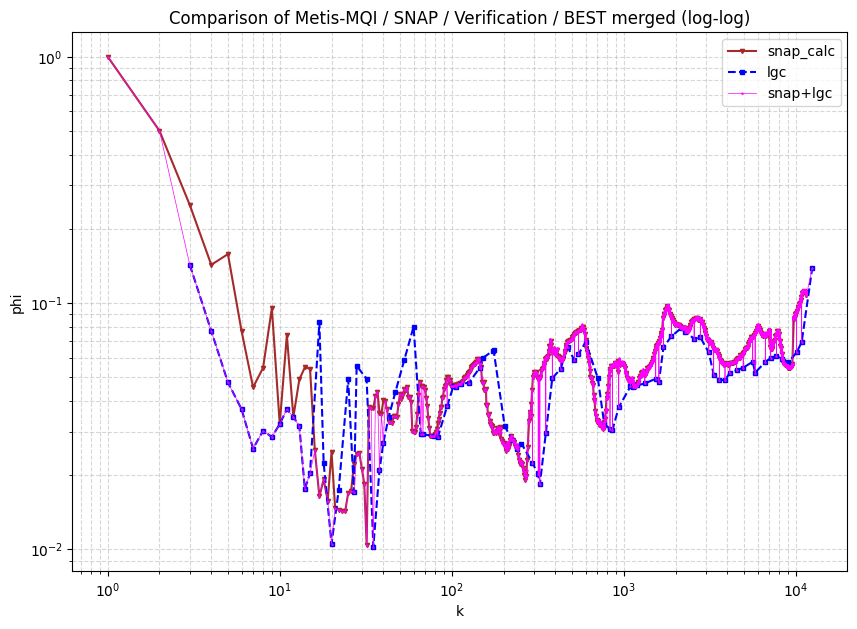

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSV file (METIS+MQI ncp.csv) ---
# csv_file = "/home/ofrie.r/ncp_expand/target/metis_mqi/ncp.csv"
# df_csv = pd.read_csv(csv_file)
# df_csv["k"] = pd.to_numeric(df_csv["k"], errors="coerce")
# df_csv["best_phi"] = pd.to_numeric(df_csv["best_phi"], errors="coerce")
# df_csv = df_csv.dropna(subset=["k", "best_phi"]).sort_values("k")

# # --- Load TAB file (SNAP NCP) ---
# tab_file = "/home/ofrie.r/ncp_expand/datasets/facebook/ncp_original_graph/ncp.facebook_combined.clusters.tab"
# df_tab = pd.read_csv(tab_file, sep="\t")
# df_tab = df_tab.rename(columns={"#Size": "k", "Phi": "phi_tab"})
# df_tab["k"] = pd.to_numeric(df_tab["k"], errors="coerce")
# df_tab["phi_tab"] = pd.to_numeric(df_tab["phi_tab"], errors="coerce")
# df_tab = df_tab.dropna(subset=["k", "phi_tab"]).sort_values("k")

# --- Load verification file ---
# ver_file = "../target/verification_results.csv"
# df_ver = pd.read_csv(ver_file)
# df_ver = df_ver.rename(columns={"ClusterSize": "k"})
# df_ver["k"] = pd.to_numeric(df_ver["k"], errors="coerce")
# df_ver["Phi_file"] = pd.to_numeric(df_ver["Phi_file"], errors="coerce")
# df_ver["Phi_calc"] = pd.to_numeric(df_ver["Phi_calc"], errors="coerce")
# df_ver = df_ver.dropna(subset=["k"]).sort_values("k")

# # --- Load BEST combined curve (METIS+MQI + SNAP) ---
# best_file = "/home/ofrie.r/ncp_expand/target/snap_metis_combined.csv"
# df_best = pd.read_csv(best_file)
# df_best["k"] = pd.to_numeric(df_best["k"], errors="coerce")
# df_best["best_phi"] = pd.to_numeric(df_best["best_phi"], errors="coerce")
# df_best = df_best.dropna(subset=["k", "best_phi"]).sort_values("k")


# --- Load snap_calc NCP tab file (Facebook Pages) ---
snap_calc_file = "/home/ofrie.r/graph-ncp-project/results/snap_calc/facebook_pages/ncp.musae_facebook_no_self_loops.tab"

df_snap_calc = pd.read_csv(
    snap_calc_file,
    sep="\t",
    comment="#",       # ignore metadata lines
    header=None,       # no header row
    names=["k", "phi"] # assign names manually
)

# Convert to numeric
df_snap_calc["k"] = pd.to_numeric(df_snap_calc["k"], errors="coerce")
df_snap_calc["phi"] = pd.to_numeric(df_snap_calc["phi"], errors="coerce")

# Drop junk rows
df_snap_calc = df_snap_calc.dropna(subset=["k", "phi"]).sort_values("k")

# --- Load LGC min-curve file ---
lgc_file = "/home/ofrie.r/graph-ncp-project/results/lgc/facebook_pages/ncp_min_clusters_by_size.csv"
df_lgc = pd.read_csv(lgc_file)
df_lgc["size"] = pd.to_numeric(df_lgc["size"], errors="coerce")
df_lgc["conductance"] = pd.to_numeric(df_lgc["conductance"], errors="coerce")
df_lgc = df_lgc.dropna(subset=["size", "conductance"]).sort_values("size")

# --- Load snap+lgc combined_min_phi CSV ---
snap_lgc_file = "/home/ofrie.r/graph-ncp-project/results/snap+lgc/facebook_pages/combined_min_phi.csv"
snap_lgc = pd.read_csv(snap_lgc_file)
snap_lgc["size"] = pd.to_numeric(snap_lgc["size"], errors="coerce")
snap_lgc["phi"] = pd.to_numeric(snap_lgc["phi"], errors="coerce")
snap_lgc = snap_lgc.dropna(subset=["size", "phi"]).sort_values("size")


# --- Merge CSV+TAB (only used for the CSV curve) ---
# merged = pd.merge(df_csv, df_tab, on="k", how="inner")
# merged["csv_le_tab"] = merged["best_phi"] > merged["phi_tab"]

# --- Plotting ---
plt.figure(figsize=(10, 7))

# # # 1️⃣ CSV curve (METIS+MQI)
# plt.loglog(df_csv["k"], df_csv["best_phi"],
#            marker='o', linestyle='-', color='red',
#            label='metis_mqi', linewidth=1, markersize=4)

# # 2️⃣ Verification curves
# plt.loglog(df_ver["k"], df_ver["Phi_file"],
#            linestyle='--', color='purple',
#            label='SNAP')

# plt.loglog(df_ver["k"], df_ver["Phi_calc"],
#            linestyle='--', color='orange',
#            label='Phi_calc (out of SNAP)')

# # 3️⃣ Best-phi-per-k curve (NEW!)
# plt.loglog(df_best["k"], df_best["best_phi"],
#            linestyle='-', color='green',
#            linewidth=2, markersize=1, marker='D',
#            label='BEST phi per k (combined)')

# SNAP_calc curve
plt.loglog(df_snap_calc["k"], df_snap_calc["phi"],
           linestyle='-', color='brown',
           marker='v', markersize=3, linewidth=1.5,
           label='snap_calc')


# LGC
plt.loglog(df_lgc["size"], df_lgc["conductance"],
           linestyle='--', color='blue',
           marker='s', markersize=3, linewidth=1.5,  
           label='lgc')

# SNAP+LGC combined curve
plt.loglog(snap_lgc["size"], snap_lgc["phi"],
           linestyle='-', color='magenta',
           linewidth=0.5, marker='^', markersize=1,
           label='snap+lgc')

# Labels, legend, grid
plt.xlabel("k")
plt.ylabel("phi")
plt.title("Comparison of Metis-MQI / SNAP / Verification / BEST merged (log-log)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

plt.show()
